#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [8]:
# Local clone
! git clone https://github.com/badreouh/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 59 (delta 21), reused 20 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 1.41 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [9]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [14]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

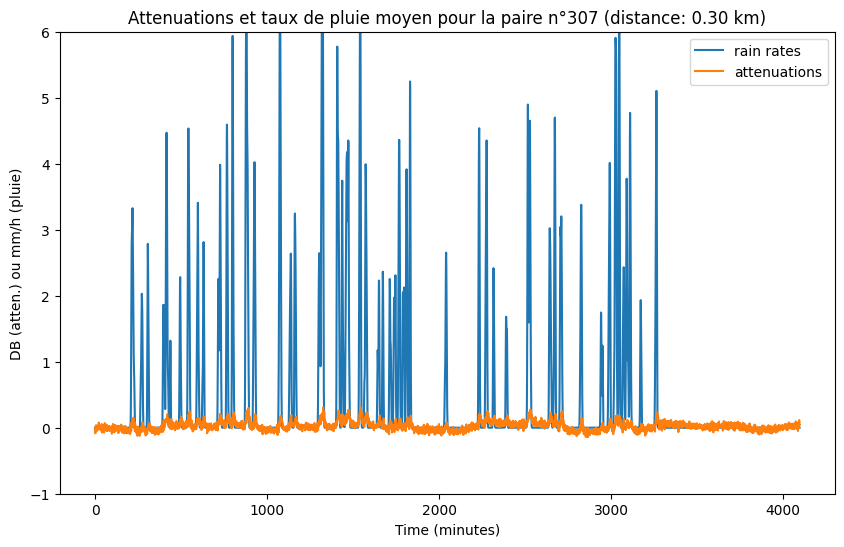

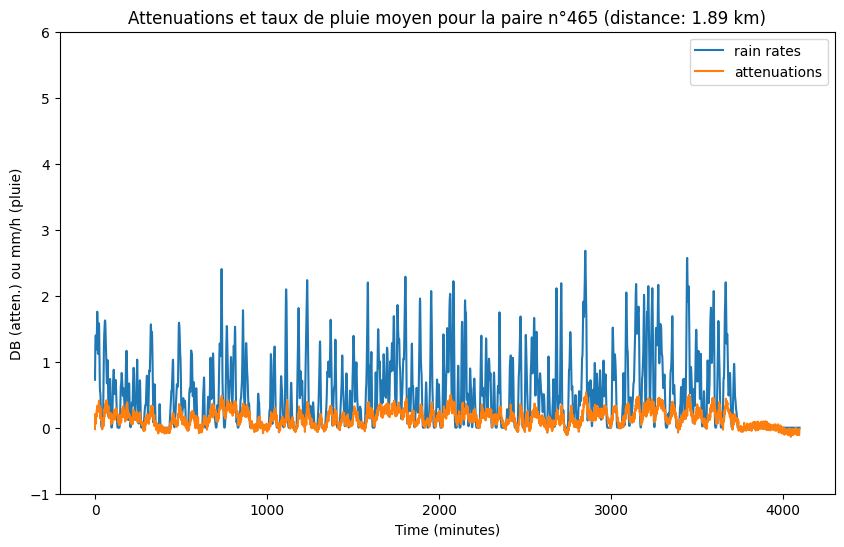

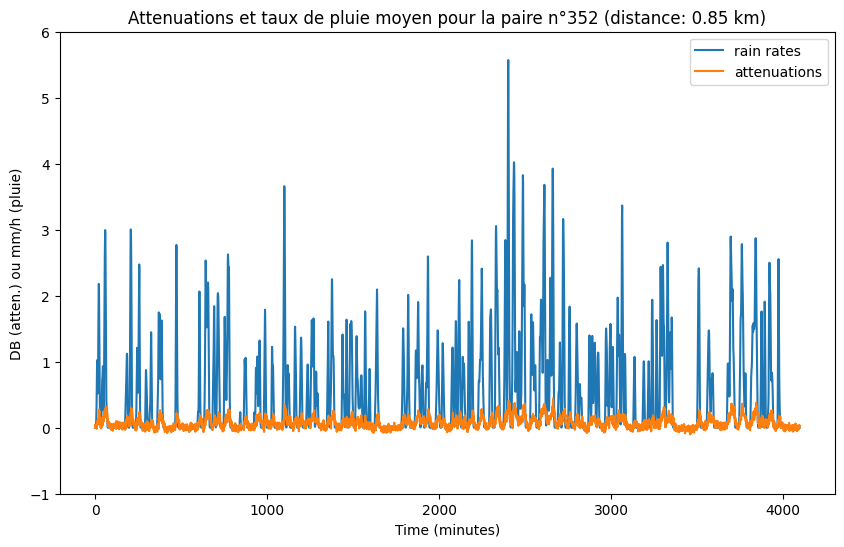

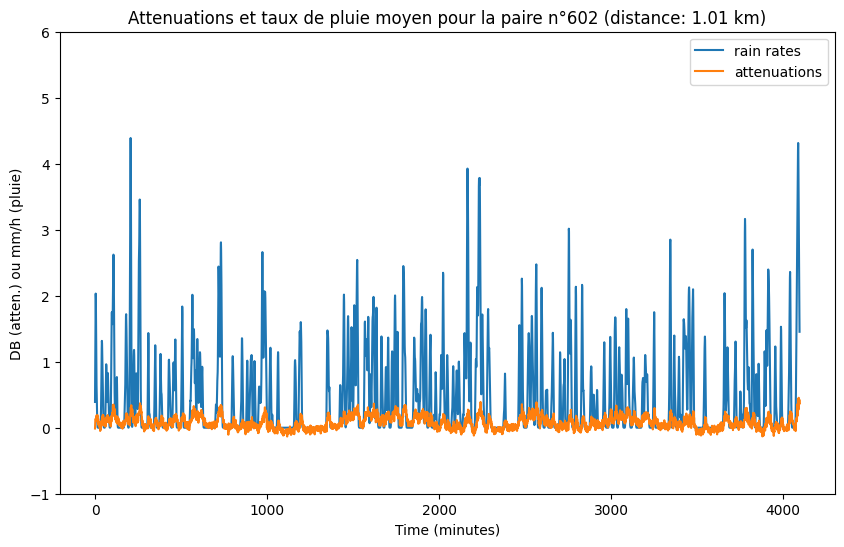

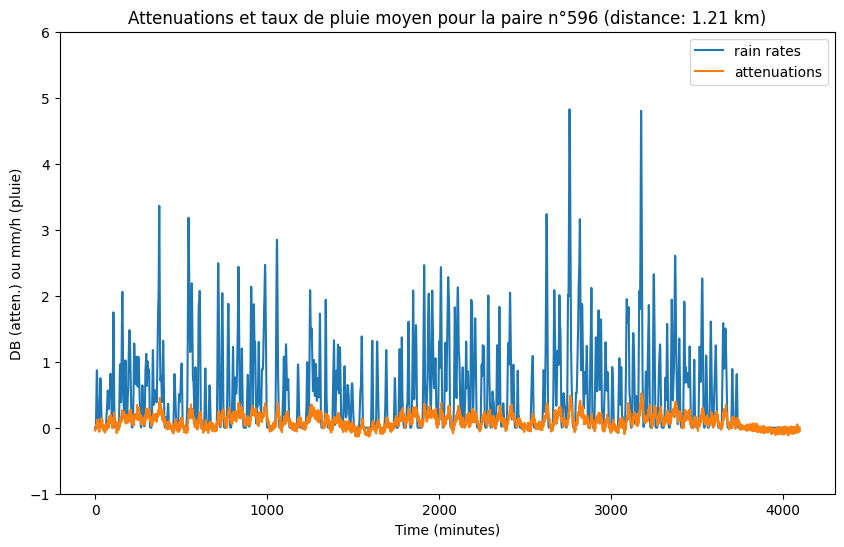

In [15]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [16]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

Époque [1/50], Loss Train: 0.7800, Loss Val: 1.0968
Époque [2/50], Loss Train: 0.3129, Loss Val: 1.0446
Époque [3/50], Loss Train: 0.1695, Loss Val: 0.8766
Époque [4/50], Loss Train: 0.1568, Loss Val: 0.5231
Époque [5/50], Loss Train: 0.1473, Loss Val: 0.3496
Époque [6/50], Loss Train: 0.1443, Loss Val: 0.2349
Époque [7/50], Loss Train: 0.1404, Loss Val: 0.1758
Époque [8/50], Loss Train: 0.1380, Loss Val: 0.1680
Époque [9/50], Loss Train: 0.1380, Loss Val: 0.1568
Époque [10/50], Loss Train: 0.1349, Loss Val: 0.1594
Époque [11/50], Loss Train: 0.1370, Loss Val: 0.1542
Époque [12/50], Loss Train: 0.1340, Loss Val: 0.1519
Époque [13/50], Loss Train: 0.1340, Loss Val: 0.1608
Époque [14/50], Loss Train: 0.1348, Loss Val: 0.1544
Époque [15/50], Loss Train: 0.1317, Loss Val: 0.1547
Époque [16/50], Loss Train: 0.1333, Loss Val: 0.1556
Époque [17/50], Loss Train: 0.1318, Loss Val: 0.1537
Époque [18/50], Loss Train: 0.1322, Loss Val: 0.1590
Époque [19/50], Loss Train: 0.1297, Loss Val: 0.1638
Ép

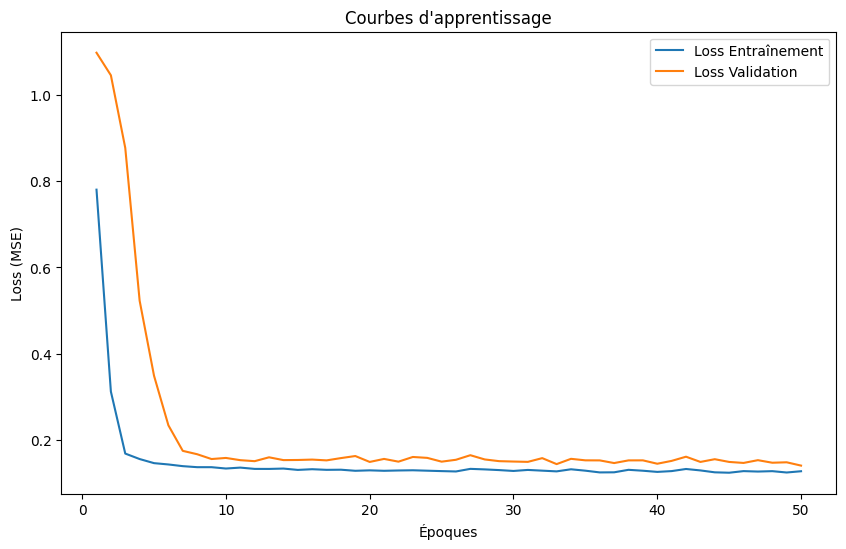

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Paramètres
n_channels = 1  # Série unidimensionnelle
n_classes = 1  # Prédiction du taux de pluie
num_epochs = 50
learning_rate = 1e-3
#batch_size = 100

# Initialisation du modèle et du GPU
model = UNet1D(n_channels, n_classes, size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Fonction de coût (MSE)
criterion = nn.MSELoss()

# Optimiseur Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Création des dataloaders pour train et validation \\ deja dréés auparavant
#trainloader = create_dataloader(duration, idx2distance_train, batch_size)
#valloader = create_dataloader(duration, idx2distance_val, batch_size)

# Entraînement du modèle
def train(model, trainloader, valloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for ids, dists, rain_rates, attenuations in trainloader:
            attenuations = attenuations.to(device).unsqueeze(1)
            rain_rates = rain_rates.to(device).unsqueeze(1)

            # Exclusion des effets de bord (2 heures = 120 minutes)
            attenuations = attenuations[:, :, 120:-120]
            rain_rates = rain_rates[:, :, 120:-120]

            optimizer.zero_grad()
            outputs = model(attenuations)
            loss = criterion(outputs, rain_rates)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ids, dists, rain_rates, attenuations in valloader:
                attenuations = attenuations.to(device).unsqueeze(1)
                rain_rates = rain_rates.to(device).unsqueeze(1)
                attenuations = attenuations[:, :, 120:-120]
                rain_rates = rain_rates[:, :, 120:-120]

                outputs = model(attenuations)
                loss = criterion(outputs, rain_rates)
                val_loss += loss.item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)

        print(f"Époque [{epoch+1}/{num_epochs}], Loss Train: {train_loss:.4f}, Loss Val: {val_loss:.4f}")

    return train_losses, val_losses

# Lancement de l'entraînement
train_losses, val_losses = train(model, trainloader, valloader, criterion, optimizer, num_epochs, device)

# Courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Loss Entraînement')
plt.plot(range(1, num_epochs + 1), val_losses, label='Loss Validation')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes d\'apprentissage')
plt.legend()
plt.show()


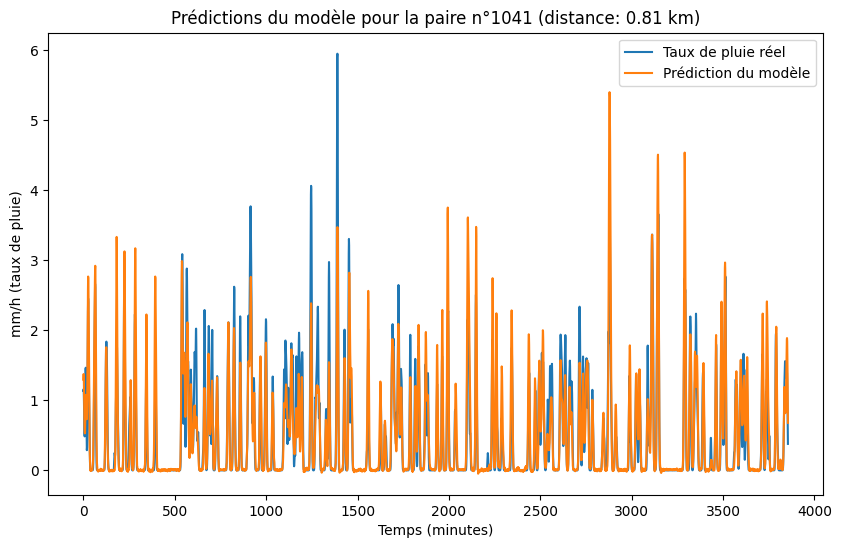

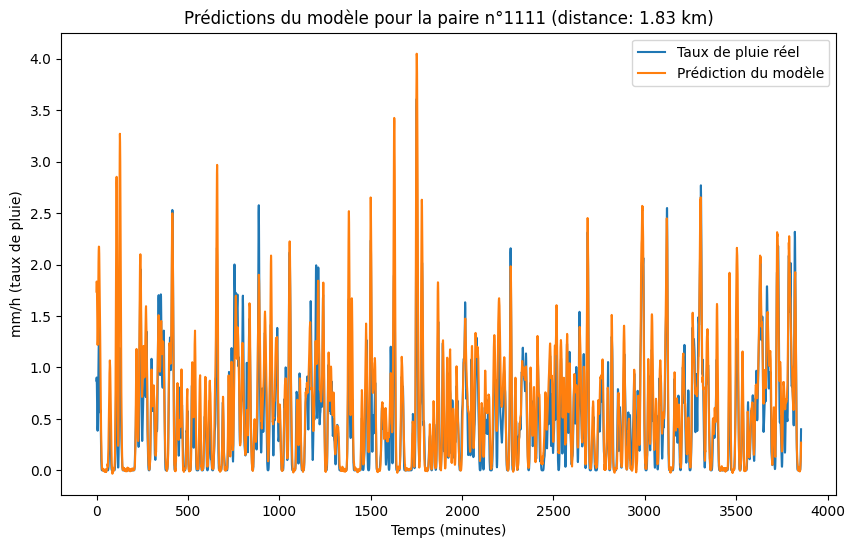

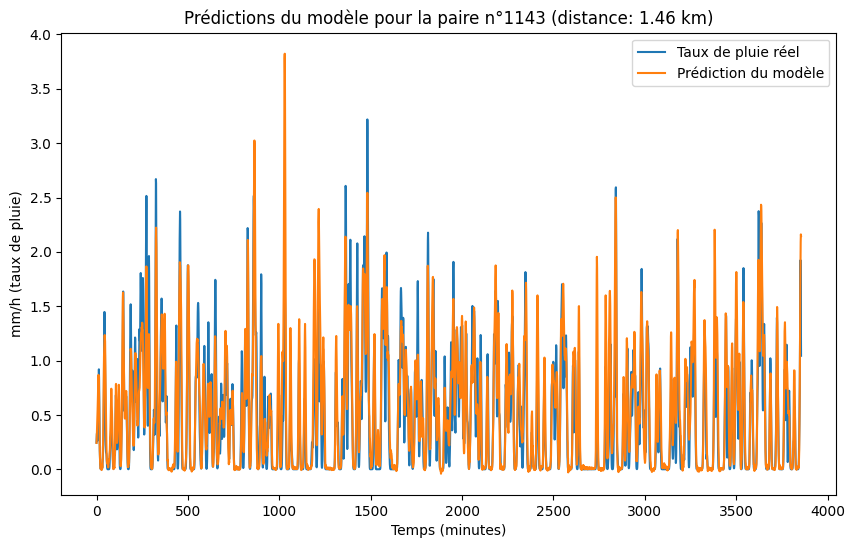

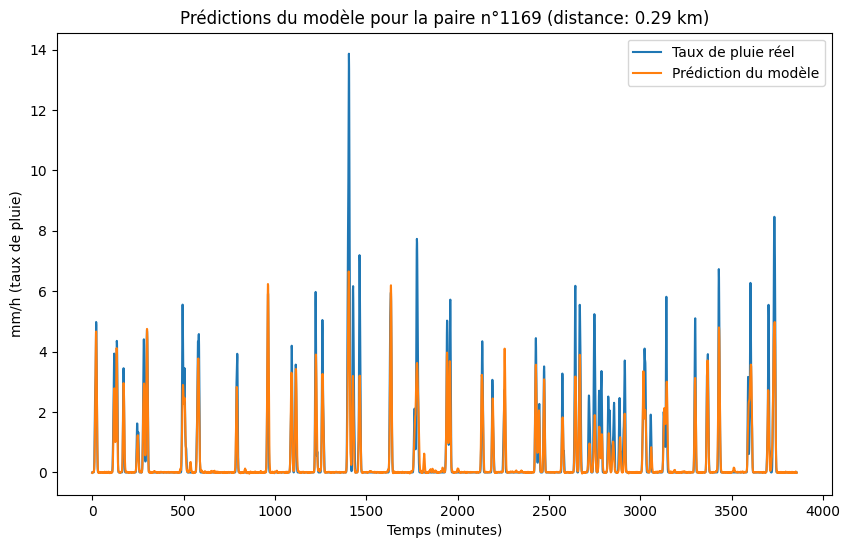

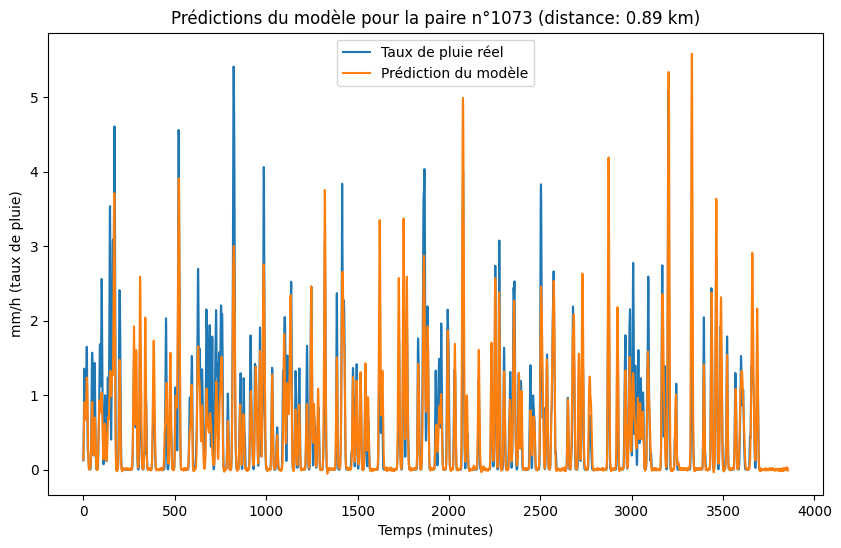

In [19]:
def visualize_predictions(model, valloader, device):
    model.eval()
    ids, dists, rain_rates, attenuations = next(iter(valloader))
    attenuations = attenuations.to(device).unsqueeze(1)
    rain_rates = rain_rates.to(device)

    with torch.no_grad():
        predictions = model(attenuations).squeeze(1).cpu().numpy()

    # Nombre de points après suppression des 2 heures de début et de fin
    valid_length = attenuations.size(-1) - 240

    for k in range(5):  # Visualiser 5 exemples
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(valid_length), rain_rates[k, 120:-120].cpu().numpy(), label='Taux de pluie réel')
        plt.plot(np.arange(valid_length), predictions[k][120:-120], label='Prédiction du modèle')
        plt.title(f"Prédictions du modèle pour la paire n°{ids[k].item()} (distance: {dists[k].item():.2f} km)")
        plt.xlabel('Temps (minutes)')
        plt.ylabel('mm/h (taux de pluie)')
        plt.legend()
        plt.show()

# Appel de la fonction
visualize_predictions(model, valloader, device)


## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [26]:
import torch.nn.functional as F

class UNet1DWithPerceptrons(nn.Module):
    def __init__(self, n_channels, n_classes, size=64, num_pairs=1200):
        super(UNet1DWithPerceptrons, self).__init__()

        # UNet de la partie I
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2 * size)
        self.down2 = Down(2 * size, 4 * size)
        self.down3 = Down(4 * size, 8 * size)
        self.down4 = Down(8 * size, 8 * size)
        self.up1 = Up(8 * size, 4 * size)
        self.up2 = Up(4 * size, 2 * size)
        self.up3 = Up(2 * size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)

        # Perceptrons spécifiques aux paires d'antennes
        self.num_pairs = num_pairs
        self.input_size_fc_layer = 5  # Taille d'entrée pour le perceptron
        self.hidden_size_fc_layer = 5  # Taille de la couche cachée du perceptron

        # Création des perceptrons (2 couches)
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer) for _ in range(self.num_pairs)])
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer, 1) for _ in range(self.num_pairs)])
        self.relu = nn.ReLU()

    def apply_perceptron(self, UNet_output, ids):
      """
      Applique le perceptron correspondant à chaque identifiant de paire d'antennes.
      """
      for i in range(ids.shape[0]):
          id = ids[i].item()  # Identifiant de la paire d'antennes
          # Application de la première couche du perceptron
          x = self.linears1[id](UNet_output[i].transpose(0, 1).contiguous())
          x = self.relu(x)
          # Application de la seconde couche
          x = self.linears2[id](x).squeeze()  # Enlever la dimension inutile pour obtenir la forme [4096]

          # Correction multiplicative de la sortie du UNet
          UNet_output[i, 0] *= (1 + x)  # Les deux tenseurs ont maintenant la même dimension [4096]
      return UNet_output[:, 0]

    def forward(self, x, ids):
        """
        Fonction forward qui applique le UNet puis le perceptron spécifique.
        """
        # UNet
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        UNet_output = self.outc(x)

        # Application du perceptron
        Z = self.apply_perceptron(UNet_output, ids)
        return Z


In [22]:
'''# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])
'''



"# Pour l'ajout de 1200 perceptrons à deux couches:\nself.num_pairs = 1200\nself.input_size_fc_layer = 5\nself.hidden_size_fc_layer = 5\n# Liste des premières couches\nself.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,\n                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])\n# Liste des secondes couches\nself.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,\n                                         1) for i in range(self.num_pairs)])\n"

**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [ ]:
#def apply_perceptron(self, UNet_output, ids):
#    for i in range(ids.shape[0]):
#        id = ids[i]
#        # application de la première couche
#        x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
#        x = self.relu(x)
#        # application de la seconde couche
#        x = self.linears2[id](x)
#        # correction multiplicative de UNet_output
#        UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous()
#    return UNet_output[:,0]


Époque [1/50], Perte Entraînement : 1.1503, Perte Validation : 0.8213
Époque [2/50], Perte Entraînement : 0.4597, Perte Validation : 0.8308
Époque [3/50], Perte Entraînement : 0.3144, Perte Validation : 0.7120
Époque [4/50], Perte Entraînement : 0.2414, Perte Validation : 0.4522
Époque [5/50], Perte Entraînement : 0.2229, Perte Validation : 0.3086
Époque [6/50], Perte Entraînement : 0.2095, Perte Validation : 0.2739
Époque [7/50], Perte Entraînement : 0.2099, Perte Validation : 0.2587
Époque [8/50], Perte Entraînement : 0.2100, Perte Validation : 0.2588
Époque [9/50], Perte Entraînement : 0.2029, Perte Validation : 0.2444
Époque [10/50], Perte Entraînement : 0.2010, Perte Validation : 0.2506
Époque [11/50], Perte Entraînement : 0.1978, Perte Validation : 0.2454
Époque [12/50], Perte Entraînement : 0.1942, Perte Validation : 0.2458
Époque [13/50], Perte Entraînement : 0.1932, Perte Validation : 0.2327
Époque [14/50], Perte Entraînement : 0.1917, Perte Validation : 0.2315
Époque [15/50],

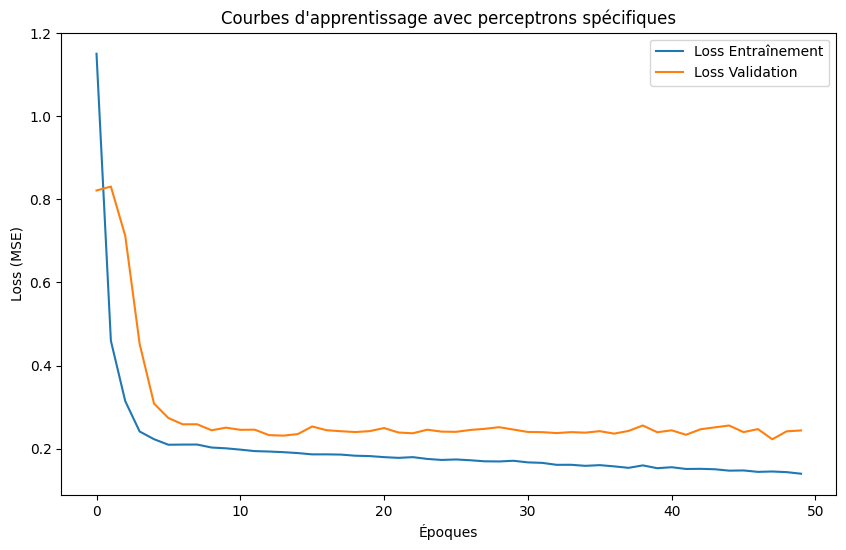

In [27]:
# Initialisation du modèle UNet avec perceptrons
model = UNet1DWithPerceptrons(n_channels=1, n_classes=5, size=32, num_pairs=1200).to(device)

num_epochs = 8
# Fonction de coût et optimiseur
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement avec dataloaders
def train_with_perceptrons(model, trainloader, valloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for ids, dists, rain_rates, attenuations in trainloader:
            attenuations = attenuations.to(device).unsqueeze(1)
            rain_rates = rain_rates.to(device).unsqueeze(1)
            ids = ids.to(device)

            optimizer.zero_grad()
            outputs = model(attenuations, ids)
            outputs = outputs[:, 120:-120]  # Exclusion des effets de bord
            rain_rates = rain_rates[:, :, 120:-120]
            loss = criterion(outputs, rain_rates.squeeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ids, dists, rain_rates, attenuations in valloader:
                attenuations = attenuations.to(device).unsqueeze(1)
                rain_rates = rain_rates.to(device).unsqueeze(1)
                ids = ids.to(device)
                outputs = model(attenuations, ids)
                outputs = outputs[:, 120:-120]
                rain_rates = rain_rates[:, :, 120:-120]
                loss = criterion(outputs, rain_rates.squeeze(1))
                val_loss += loss.item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)

        print(f"Époque [{epoch+1}/{num_epochs}], Perte Entraînement : {train_loss:.4f}, Perte Validation : {val_loss:.4f}")

    return train_losses, val_losses

# Lancement de l'entraînement
train_losses, val_losses = train_with_perceptrons(model, trainloader, valloader, criterion, optimizer, num_epochs=50, device=device)

# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Loss Entraînement')
plt.plot(val_losses, label='Loss Validation')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes d\'apprentissage avec perceptrons spécifiques')
plt.legend()
plt.show()


# ** Réponse 4 - Analyse des performances et commentaires**

## **Éléments à surveiller :**

### **Paires du jeu d'entraînement :**
- Le modèle doit avoir une perte en généralisation faible si le UNet et les perceptrons spécifiques apprennent bien les variations des séries temporelles associées aux paires.

### **Paires de validation indépendantes :**
- Les performances sur les paires de validation peuvent indiquer si le modèle est capable de généraliser ou si l'ajout des perceptrons introduit un sur-ajustement.


## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité

In [ ]:
class UNet1DWithPerceptronsAndGeneric(nn.Module):
    def __init__(self, n_channels, n_classes, size=64, num_pairs=1200):
        super(UNet1DWithPerceptronsAndGeneric, self).__init__()

        # UNet
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2 * size)
        self.down2 = Down(2 * size, 4 * size)
        self.down3 = Down(4 * size, 8 * size)
        self.down4 = Down(8 * size, 8 * size)
        self.up1 = Up(8 * size, 4 * size)
        self.up2 = Up(4 * size, 2 * size)
        self.up3 = Up(2 * size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)

        # Perceptrons spécifiques
        self.num_pairs = num_pairs
        self.input_size_fc_layer = 5
        self.hidden_size_fc_layer = 5
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer) for _ in range(self.num_pairs)])
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer, 1) for _ in range(self.num_pairs)])

        # Perceptron générique
        self.generic_linear1 = nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer)
        self.generic_linear2 = nn.Linear(self.hidden_size_fc_layer, 1)
        self.relu = nn.ReLU()

    def apply_perceptron(self, UNet_output, ids):
        outputs = []
        for i in range(ids.shape[0]):
            id = ids[i].item()
            if torch.rand(1).item() < 0.25:  # 25% du temps, on utilise le perceptron générique
                x = self.generic_linear1(UNet_output[i].transpose(0, 1).contiguous())
                x = self.relu(x)
                x = self.generic_linear2(x).squeeze()
            else:  # 75% du temps, on utilise le perceptron spécifique
                x = self.linears1[id](UNet_output[i].transpose(0, 1).contiguous())
                x = self.relu(x)
                x = self.linears2[id](x).squeeze()
            # Correction multiplicative
            outputs.append((1 + x) * UNet_output[i, 0])
        return torch.stack(outputs, dim=0)

    def forward(self, x, ids):
        # UNet forward pass
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        UNet_output = self.outc(x)
        return self.apply_perceptron(UNet_output, ids)


In [ ]:
##Fonction d'entraînement avec phase de gel:

def train_with_generic_perceptron(model, trainloader, valloader, criterion, optimizer, device, num_epochs=50, freeze_after=50):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for ids, dists, rain_rates, attenuations in trainloader:
            attenuations = attenuations.to(device).unsqueeze(1)
            rain_rates = rain_rates.to(device).unsqueeze(1)
            ids = ids.to(device)

            optimizer.zero_grad()
            outputs = model(attenuations, ids)
            outputs = outputs[:, 120:-120]  # Exclusion des bords
            rain_rates = rain_rates[:, :, 120:-120]
            loss = criterion(outputs, rain_rates.squeeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ids, dists, rain_rates, attenuations in valloader:
                attenuations = attenuations.to(device).unsqueeze(1)
                rain_rates = rain_rates.to(device).unsqueeze(1)
                ids = ids.to(device)
                outputs = model(attenuations, ids)
                outputs = outputs[:, 120:-120]
                rain_rates = rain_rates[:, :, 120:-120]
                loss = criterion(outputs, rain_rates.squeeze(1))
                val_loss += loss.item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)

        print(f"Époque [{epoch+1}/{num_epochs}], Loss Train : {train_loss:.4f}, Loss Val : {val_loss:.4f}")

        # Après un certain nombre d'époques, on gèle le UNet et le perceptron générique
        if epoch == freeze_after:
            for param in model.inc.parameters():
                param.requires_grad = False
            for param in model.generic_linear1.parameters():
                param.requires_grad = False
            for param in model.generic_linear2.parameters():
                param.requires_grad = False

    return train_losses, val_losses


In [ ]:
# Initialisation du modèle
model = UNet1DWithPerceptronsAndGeneric(n_channels=1, n_classes=5, size=32, num_pairs=1200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement
train_losses, val_losses = train_with_generic_perceptron(model, trainloader, valloader, criterion, optimizer, device, num_epochs=70, freeze_after=50)

# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Loss Entraînement')
plt.plot(val_losses, label='Loss Validation')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes d\'apprentissage avec perceptron générique et phase de gel')
plt.legend()
plt.show()


# 2. Conclusion sur l'efficacité :
## Critères d'évaluation :

 ### Performance sur les paires du jeu d'entraînement :
 La perte doit diminuer régulièrement, montrant que les perceptrons spécifiques
 continuent à s'améliorer même après le gel.

 ### Généralisation aux paires de validation :
 Les performances doivent être meilleures que dans la partie II sur les paires
 non vues pendant l'entraînement.

## Points d'observation :
 Si la perte en validation reste stable ou diminue après l'introduction du perceptron générique,
 la généralisation est réussie.
 Si la perte augmente fortement après le gel, cela peut indiquer un besoin
 d’augmenter la taille du perceptron générique ou d'améliorer la régularisation.
